# Funciones para detección de espiguletas (*spiklets*)

Este cuaderno contiene funciones, graficas y pruebas para la detección automática de espiguletas.
Empezamos por cargar las bibliotecas necesarias de uso general.

In [1]:
using PyPlot, HDF5
using Statistics

El archivo adjunto **sacadatos.jl** contiene funciones para abrir y ordenar un archivo tipo *hdf5* del programa *Stimfit*.

In [2]:
include("sacadatos.jl")

devuelvedatos (generic function with 1 method)

In [3]:
nomine = "../h5files/180718_9.hf5"

"../h5files/180718_9.hf5"

In [4]:
datos = h5open(nomine, "r");
names(datos)

5-element Array{String,1}:
 "Im_primaryIm_sec"
 "Im_sec"          
 "channels"        
 "comment"         
 "description"     

In [5]:
constantes, sweps = devuelvedatos(datos, "Im_primaryIm_sec");
const freq=1/constantes[1];
println("la frequencia de muestreo es ", freq, " kHz." )

la descripcion de tus barridas de datos son las siguientes
HDF5.HDF5Compound{3}[HDF5Compound{3}((0.04, "ms", "mV"), ("dt", "xunits", "yunits"), (Float64, String, String))]
la frequencia de muestreo es 25.0 kHz.


In [6]:
const prevGms=10
const postGms=40
const preG=round(Int, prevGms*freq)
const posG=round(Int, postGms*freq)

1000

Funciones auxiliares para convertir tiempo (en ms) a intervalos (en indices enteros) y viceversa:

In [7]:
function iart(i::Int,f::Int) 
  #  """function que pasa de intervalos enteros a tiempo en ms"""
aux=i:f
    result=aux./freq
end

function tari(it,ft)
    # funtion que pasa de tiempo en ms a intervalos enteros de indices
    auxi=round(Int, it*freq)
    auxf=round(Int, ft*freq)
    result=auxi:auxf
end

function derivadadt(xx::Array, f=freq)
    aux=diff(xx).*f
    result=vcat(aux, aux[end])
end

derivadadt (generic function with 2 methods)

Funciones de suavizado (duro y gaussiano), e.g. $ \tilde{x}= \sum_{-2}^{2} x_i /N$

In [8]:
function suaveduro(trazo::Array, nv=9)
# funcion que promedia cada punto sobre sus vecinos
    aux=trazo
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        result[j]=mean(aux[j:j+nv*2])
    end
    return result 
end


gauss(x, sigma)=exp(-(x/sigma)^2/2)

function pesosgauss(desv::Real,n::Int)
# funcion que promedia cada punto sobre sus vecinos, pero con peso gaussiano
    g=zeros(2*n+1)
    for j=-n:n
        g[j+n+1]=gauss(j,desv)
    end
    return g
end
        
function suavegauss(trazo::Array, nv=10)
    aux=trazo
    pesos=pesosgauss(nv/2,nv)
    pesoT=sum(pesos)
    l=length(trazo)
    cabeza=repeat([trazo[1]],nv)
    cola=repeat([trazo[end]],nv)
    aux=vcat(cabeza,aux,cola)
    result=zeros(l)
    for j=1:l
        for k=0:2*nv
        result[j]+=aux[j+k]*pesos[k+1]
        end
    end
    result/=pesoT
    return result 
end

suavegauss (generic function with 2 methods)

La siguiente funcion, **intervalosP**, determina, a partir de la derivada suavizada de un trazo, los intervalos donde posiblemente hay una espiguleta o una espiga, es decir, aquellos cuya derivada es mayor a cierto umbral. 

In [9]:
const uinfc=0.06*freq # los umbrales por default. ¡¡Dependene de la taza de muestreo!!
const usupc=0.5*freq

function intervalosP(dtrazo::Array,thres=uinfc, thres2=usupc)
    # recuerdese: dtrazo es la DERIVADA del trazo suavizado, no el trazo.
    #se recomienda usar una diferencia suavizada en dtrazo
    esunbrinco(x)=  x>thres 
    escontiguo(x,y)=(y-x)==1
    result=Dict{Int, Any}()
    preresult=Dict{Int, Array}()
    
    #=
    Este primer loop encuentra los intervalos
    de INDICES contiguos que cumplen estar
    por encima del umbral
    =#
    r=findall(esunbrinco,dtrazo)
    
    if !(isempty(r))
        k=1
        preresult[1]=[]
        for j=1:length(r)-1   
            if escontiguo(r[j], r[j+1])
                push!(preresult[k], r[j+1])
            else
                k+=1
                preresult[k]=[]
            end
         end 
    
        n=length(keys(preresult))
        
    else 
        println("no hay naaaaaada en la seccion")
    end
    
    tamanointervalo=length(dtrazo)
   
    #=
    A partir del diccionario obtenido en el loop anterior:
    1) Buscamos el maximo
    2) Vemos si su valor esta debajo del segundo umbral
    3) si si, procedemos a localizar su posicion en la lista ORIGINAL de datos
    4) devolvemos una lista con todos los numeritos en ese rango de 200 antes a 800 despues
    =#
     n=length(keys(preresult))
    if n>0    
    for j in keys(preresult)
        aux=preresult[j]
        (a, lugarlista) =findmax(dtrazo[aux[1]:aux[end]])
          #  println(aux)
        if a<thres2
            lugarreal=aux[lugarlista]
            ai=lugarreal-preG
            af=lugarreal+posG
            (ai<1) ? ai=1 : ai=ai
            (af>tamanointervalo) ? af=tamanointervalo : af=af
            (maximototal, b)=findmax(dtrazo[ai:af])  
            println("vamos bien, ", ai, " ", af, " ", maximototal)
         
            if maximototal<thres2
                result[j]=ai:af
            end
                
                end # Este cierra el a<thres2 .
        
    end
    
    else
       # println(" te dije que no hay naaaada")
    end
    
    return result
end

println(" tus umbrales para la derivada posible del spiklet son ", uinfc,"  ", usupc, " en [mV/ms]")

 tus umbrales para la derivada posible del spiklet son 1.5  12.5 en [mV/ms]


### Estas funciones auxiliares causan extrema sensitividad en la deteccion

la función **g0** produce un offset o desplazamiento del arreglo (Array) por el valor d1. 

Si le mueves puede fallar la deteccion de posibles intervalos.
Una celula sana debe tener un valor d1 entre [-70, -55]

In [10]:
g0(xs::Array ,d1=-71)= xs.-(xs[1]+d1) 

g0 (generic function with 2 methods)

In [11]:
function average1(ints::Dict, data::Dict)
    #= Funcion que toma un diccionario
    de intervalos y otro de arrays de valores.
    Si todos los intervalos miden lo mismo
    promedia el valor de los valores...
    =#
    aux=0
    k=0
    for subs in keys(ints)
        for j in keys(ints[subs])
            rango=ints[subs][j]
            valor=data[subs][rango]
            aux=aux.+valor
            k+=1
        end
    end
    result=aux./k
end

average1 (generic function with 1 method)

In [12]:
function risetime(derivada::Array, thresmin=0.25)
    #= la funcion busca donde pasamos el umbral thresmin, 
     y a partir de ahi el primer indice donde los valores de "derivada" 
     se vuelven negativos =#
    pasaumbral(x)= x > thresmin
    esnegativa(x) = sign(x)==-1
    
    aux1=findfirst(pasaumbral, derivada)
    aux2=findfirst(esnegativa, derivada[aux1:end])
    aux2=aux2+aux1
    # nos devuelve ambos indices absolutos
    result=(aux1, aux2)

end


risetime (generic function with 2 methods)

In [13]:
sign(-20.1)==-1

true

In [14]:
preG

250

In [15]:
function separamochas(datos::Dict)
    #= Dado que nuestras funciones nos devuelven
    diccionarios de arrays o de rangos,
    puede darse el caso de que sean desiguales.
    Esta funcion quita los rangos o intervalos mochos.
    =#
    
Limpias=Dict{String,Dict}()
Mochas=Dict{String,Dict}()
    #preG y posG son la amplitud de busqueda en cuadros (frames)
    # previa al evento sospechoso y posterior al evento sospechoso
longi=preG+posG+1
    
    for subs in keys(datos)
    for j in keys(datos[subs])
            
        Limpias[subs]=Dict{Int, Array}()
        Mochas[subs]=Dict{Int, Array}()    
            # Primero verificamos que la longitud sea la correcta
        if length(datos[subs][j])==longi
            Limpias[subs][j]=datos[subs][j]
        else
            Mochas[subs][j]=datos[subs][j]
        end
        # Despues le quitamos los intervalos vacios
        if isempty(Limpias[subs])
            delete!(Limpias, subs)
        end
        
        if isempty(Mochas[subs])
            delete!(Mochas, subs)
        end
       
    end
end

result=(Limpias, Mochas)
end

separamochas (generic function with 1 method)

# A partir de aquí viene la numérica sucia: vamos a cargar todos los intervalos de un segundo que a ojo de buen cubero tienen una espiguelta.

In [16]:
sospechosas=[14,16,18,24,28,30,41,44]
ksuspect=[]
subs="section_"
for s in sospechosas
    aux=subs*"$s"
    push!(ksuspect, aux)
end
push!(ksuspect, "section_01")
push!(ksuspect, "section_02")
push!(ksuspect, "section_46")
push!(ksuspect, "section_47")
todas=keys(sweps);

In [17]:
suaves=Dict{String, Array}()
derivadas=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    suaves[subs]=suavegauss(sweps[subs])
    derivadas[subs]=derivadadt(suaves[subs])
    
end


In [18]:
derivadas

Dict{String,Array} with 59 entries:
  "section_57" => [0.0227465, 0.0143575, 0.00243276, -0.0125048, -0.0380098, -0…
  "section_44" => [-0.0175467, -0.0236856, -0.0307185, -0.0382777, -0.0458267, …
  "section_06" => [-0.040224, -0.0407104, -0.038174, -0.0323906, -0.0235819, -0…
  "section_13" => [0.0527132, 0.066798, 0.0743488, 0.0891968, 0.0894934, 0.0940…
  "section_17" => [0.0124304, 0.00914632, -0.00368883, -0.0124892, -0.0138579, …
  "section_56" => [-0.095921, -0.114081, -0.131372, -0.146541, -0.158394, -0.16…
  "section_12" => [0.0300359, 0.0497732, 0.0583524, 0.0740537, 0.0987841, 0.118…
  "section_41" => [-0.040224, -0.0407104, -0.038174, -0.0323906, -0.0235819, -0…
  "section_16" => [0.0639096, 0.062888, 0.0639624, 0.0692115, 0.0650987, 0.0575…
  "section_09" => [0.0210301, 0.0300359, 0.0412323, 0.0544041, 0.0689962, 0.084…
  "section_58" => [-0.0382777, -0.0543676, -0.0652024, -0.0758038, -0.0855451, …
  "section_07" => [0.0407104, 0.038174, 0.0323906, 0.0235819, 0.0124304, 

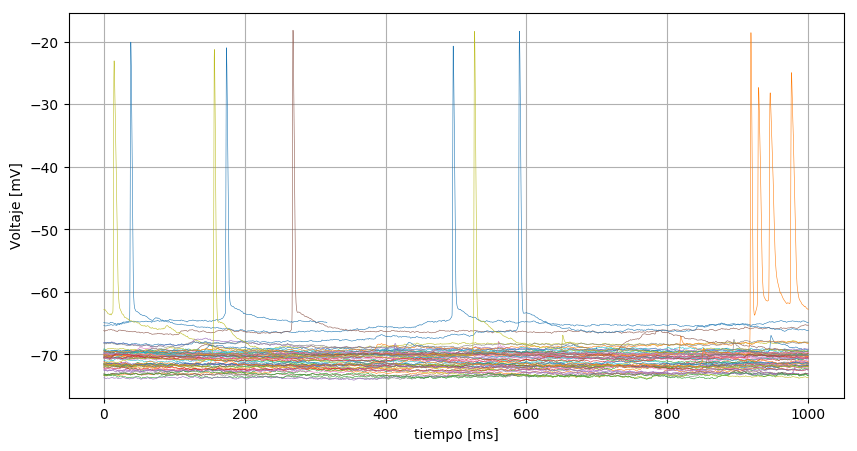

In [19]:
figura=figure(figsize=(10,5))
for subs in keys(suaves)
    lala=length(suaves[subs])
rangot=iart(1, lala)  
 plot(rangot,suaves[subs], label=subs, lw=0.4)
end

xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
#legend()
grid()

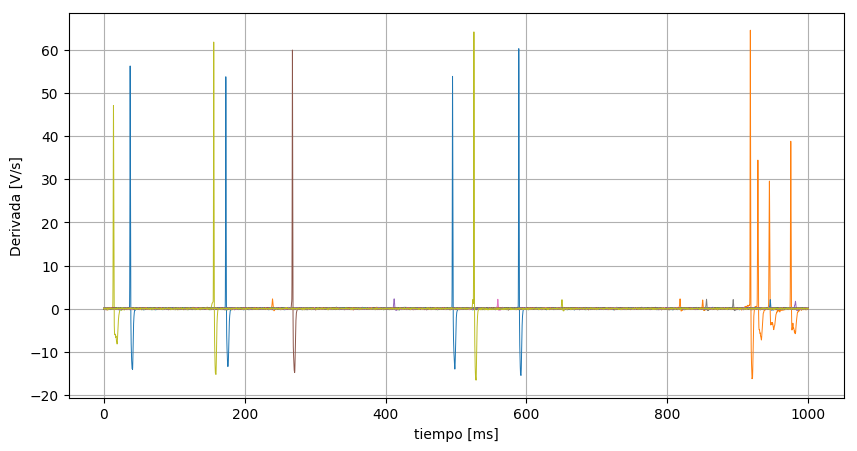

In [20]:
figura=figure(figsize=(10,5))
#ylim(-0.02, 0.5)
for subs in keys(derivadas)
lala=length(derivadas[subs])
rangot=iart(1, lala)    
 plot(rangot,derivadas[subs], label=subs, lw=0.7)
end
xlabel("tiempo [ms]")
ylabel("Derivada [V/s]")
#legend()
grid()

In [21]:
intSS=Dict{String,Dict}()  #intSS es subintervalo del intervalo
for subs in keys(derivadas)
    println(subs)
 intSS[subs]=intervalosP(derivadas[subs], 0.06*freq, 0.4*freq)
end

section_57
section_44
vamos bien, 5738 6988 2.2701333013078084
section_06
no hay naaaaaada en la seccion
section_13
no hay naaaaaada en la seccion
section_17
no hay naaaaaada en la seccion
section_56
section_12
no hay naaaaaada en la seccion
section_41
vamos bien, 21138 22388 2.1848843903079285
section_16
vamos bien, 16009 17259 2.091532496833537
section_09
no hay naaaaaada en la seccion
section_58
section_07
no hay naaaaaada en la seccion
section_43
no hay naaaaaada en la seccion
section_29
no hay naaaaaada en la seccion
section_39
no hay naaaaaada en la seccion
section_40
no hay naaaaaada en la seccion
section_10
no hay naaaaaada en la seccion
section_04
no hay naaaaaada en la seccion
section_45
section_00
no hay naaaaaada en la seccion
section_32
no hay naaaaaada en la seccion
section_36
no hay naaaaaada en la seccion
section_47
no hay naaaaaada en la seccion
section_49
no hay naaaaaada en la seccion
section_46
vamos bien, 24294 25000 1.7132576256088328
section_03
no hay naaaaaada e

In [22]:
intSS

Dict{String,Dict} with 59 entries:
  "section_57" => Dict{Int64,Any}()
  "section_44" => Dict{Int64,Any}(1=>5738:6988)
  "section_06" => Dict{Int64,Any}()
  "section_13" => Dict{Int64,Any}()
  "section_17" => Dict{Int64,Any}()
  "section_56" => Dict{Int64,Any}()
  "section_12" => Dict{Int64,Any}()
  "section_41" => Dict{Int64,Any}(1=>21138:22388)
  "section_16" => Dict{Int64,Any}(1=>16009:17259)
  "section_09" => Dict{Int64,Any}()
  "section_58" => Dict{Int64,Any}()
  "section_07" => Dict{Int64,Any}()
  "section_43" => Dict{Int64,Any}()
  "section_29" => Dict{Int64,Any}()
  "section_39" => Dict{Int64,Any}()
  "section_40" => Dict{Int64,Any}()
  "section_10" => Dict{Int64,Any}()
  "section_04" => Dict{Int64,Any}()
  "section_45" => Dict{Int64,Any}()
  "section_00" => Dict{Int64,Any}()
  "section_32" => Dict{Int64,Any}()
  "section_36" => Dict{Int64,Any}()
  "section_47" => Dict{Int64,Any}()
  "section_49" => Dict{Int64,Any}()
  "section_46" => Dict{Int64,Any}(1=>24294:25000)
  ⋮        

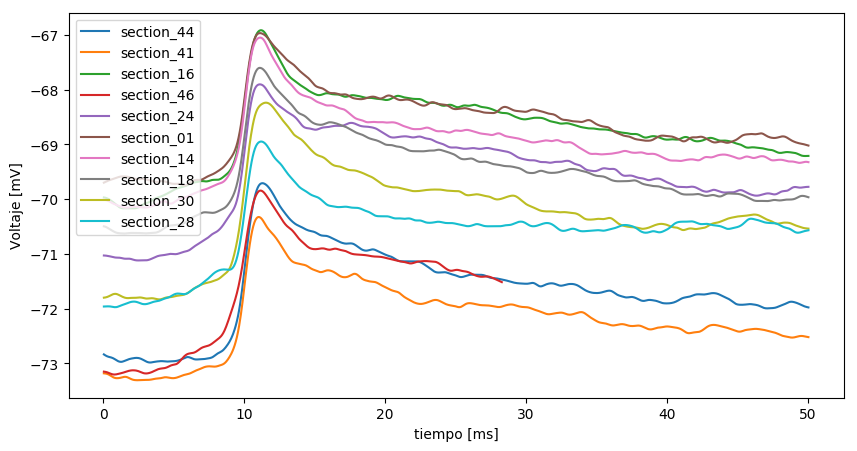

PyObject <matplotlib.legend.Legend object at 0x7fcb980c7c18>

In [23]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,suaves[subs][rango], label=subs)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
legend()

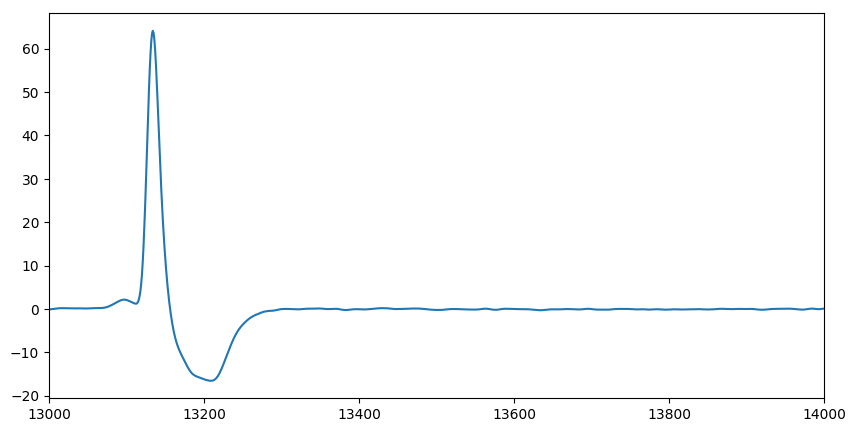

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcb98d5c390>

In [24]:
figura=figure(figsize=(10,5))
xlim(13000,14000)
#ylim(-0.02,0.1)
  #rango=intSS[subs][1]
plot(derivadas["section_50"])
#plot(suaves["section_50"])

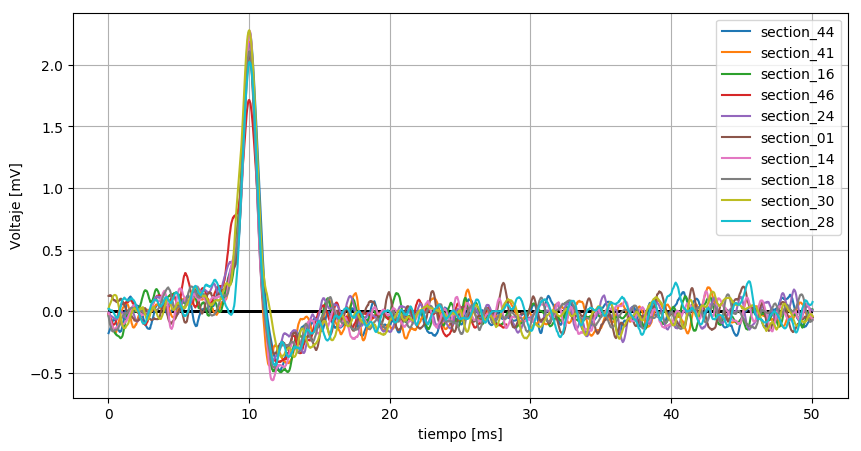

PyObject <matplotlib.legend.Legend object at 0x7fcb98d429b0>

In [25]:
figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,derivadas[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
legend()

In [26]:
(limpia, mocha)=separamochas(intSS);

In [27]:
ddt=Dict{String, Array}()
for subs in todas # aqui estaba ksuspect que era la prueba de las conocidas
    ddt[subs]=derivadadt(derivadas[subs])    
end

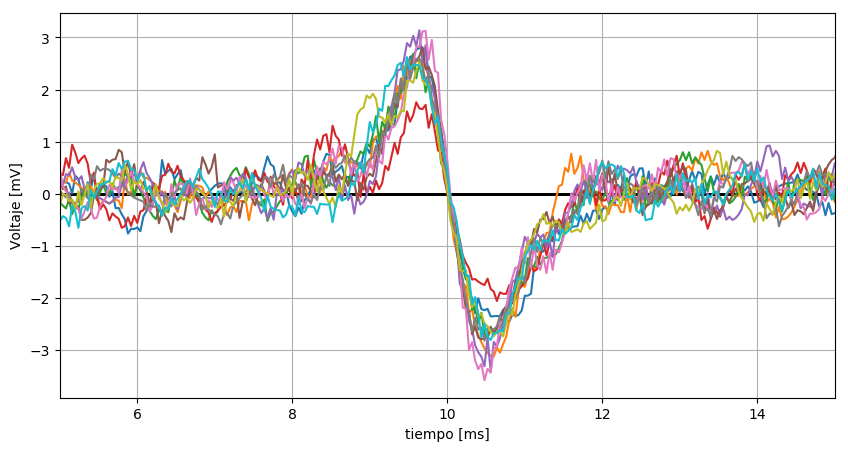

In [28]:
figura=figure(figsize=(10,5))

xlim(5,15)
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(intSS)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(intSS[subs])
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        plot(rangot,ddt[subs][rango], label=subs)
        hlines(0, 0, 50,lw=2)
    end
end


xlabel("tiempo [ms]")
ylabel("Voltaje [mV]")
grid()
#legend()

In [29]:
a=average1(limpia, suaves); # de ahora en adelante asi se sacan promedios sobre intervalos!
a[1]

-71.22069968142677

In [30]:
intSS

Dict{String,Dict} with 59 entries:
  "section_57" => Dict{Int64,Any}()
  "section_44" => Dict{Int64,Any}(1=>5738:6988)
  "section_06" => Dict{Int64,Any}()
  "section_13" => Dict{Int64,Any}()
  "section_17" => Dict{Int64,Any}()
  "section_56" => Dict{Int64,Any}()
  "section_12" => Dict{Int64,Any}()
  "section_41" => Dict{Int64,Any}(1=>21138:22388)
  "section_16" => Dict{Int64,Any}(1=>16009:17259)
  "section_09" => Dict{Int64,Any}()
  "section_58" => Dict{Int64,Any}()
  "section_07" => Dict{Int64,Any}()
  "section_43" => Dict{Int64,Any}()
  "section_29" => Dict{Int64,Any}()
  "section_39" => Dict{Int64,Any}()
  "section_40" => Dict{Int64,Any}()
  "section_10" => Dict{Int64,Any}()
  "section_04" => Dict{Int64,Any}()
  "section_45" => Dict{Int64,Any}()
  "section_00" => Dict{Int64,Any}()
  "section_32" => Dict{Int64,Any}()
  "section_36" => Dict{Int64,Any}()
  "section_47" => Dict{Int64,Any}()
  "section_49" => Dict{Int64,Any}()
  "section_46" => Dict{Int64,Any}(1=>24294:25000)
  ⋮        

In [31]:
function normCut(datossuave, intervaloslimpios, intervalossospechos)

    a=average1(intervaloslimpios, datossuave) # de ahora en adelante asi se sacan promedios sobre intervalos!
    offset=a[1]
    result=Dict{String,Dict}()
    
   for subs in keys(intervaloslimpios)
    result[subs]=Dict{Int, Array}()
    for j in keys(intervaloslimpios[subs])
         arre=intervalossospechos[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        #normCut[subs][j]=suaves[subs][rango].-(suaves[subs][rango][1]-a[1])
        result[subs][j]=g0(datossuave[subs][rango],a[1]) # g0 es la funcion que empareja el punto de inicio
   
    end
        
    end
    return result
end

normCut (generic function with 1 method)

In [32]:
normalized=normCut(suaves, limpia, intSS)

Dict{String,Dict} with 9 entries:
  "section_16" => Dict{Int64,Array}(1=>[71.2207, 71.2193, 71.2172, 71.2144, 71.…
  "section_18" => Dict{Int64,Array}(1=>[71.2207, 71.2191, 71.2163, 71.2125, 71.…
  "section_44" => Dict{Int64,Array}(1=>[71.2207, 71.2136, 71.207, 71.2007, 71.1…
  "section_14" => Dict{Int64,Array}(1=>[71.2207, 71.2202, 71.2191, 71.2172, 71.…
  "section_24" => Dict{Int64,Array}(1=>[71.2207, 71.2202, 71.2197, 71.2188, 71.…
  "section_30" => Dict{Int64,Array}(1=>[71.2207, 71.2217, 71.2232, 71.2252, 71.…
  "section_28" => Dict{Int64,Array}(1=>[71.2207, 71.2214, 71.2222, 71.2227, 71.…
  "section_01" => Dict{Int64,Array}(1=>[71.2207, 71.2257, 71.2307, 71.2359, 71.…
  "section_41" => Dict{Int64,Array}(1=>[71.2207, 71.2199, 71.2185, 71.2169, 71.…

In [33]:
normCut

normCut (generic function with 1 method)

In [34]:
mocha

Dict{String,Dict} with 1 entry:
  "section_46" => Dict{Int64,Array}(1=>[24294, 24295, 24296, 24297, 24298, 2429…

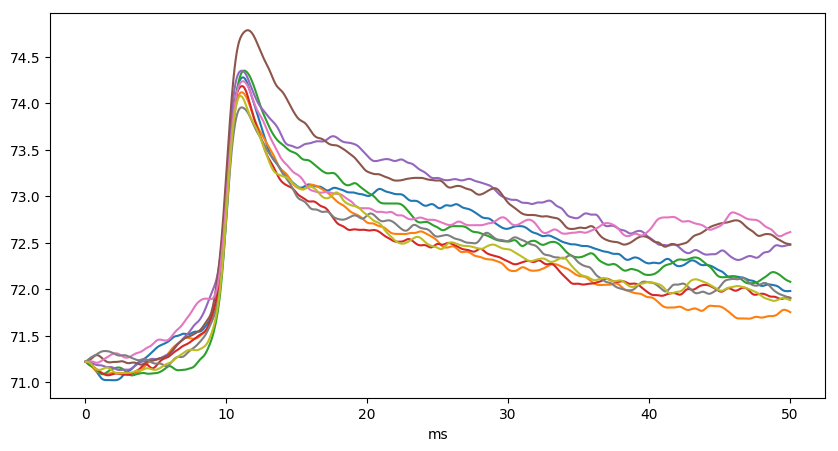

PyObject Text(0.5,24,'ms')

In [35]:
figura=figure(figsize=(10,5))
rangot=0
# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(normalized)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(normalized[subs])
           rango=intSS[subs][j]
        ll=length(rango)
        rangot=iart(1,ll)
        # tomamos el rango de cada subintervalo sospechoso
        # es mejor dibujar con rangos que con listas de numeros
        plot(rangot,normalized[subs][j])
    end
end

 xlabel("ms")
#plot(a, lw=3)

**NOTA para avanzar**

En la grafica superior, la linea gruesa es el promedio. Nos interesa calcular el tiempo que le lleva levantarse desde
el cambio en la curvatura (suave a muy empinado) hasta el máximo punto de la funcion.

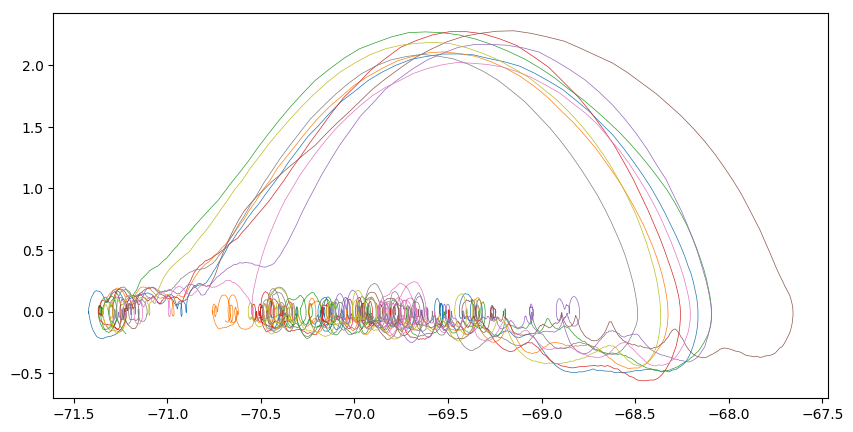

In [36]:

figura=figure(figsize=(10,5))

# Primero buscamos la lista de los intervalos ejemplo
for subs in keys(limpia)
    # en cada intervalo ejemplo puede haber varios subintervalos sospechosos
    for j in keys(limpia[subs])
        # tomamos el rango de cada subintervalo sospechoso
        arre=limpia[subs][j]
        # es mejor dibujar con rangos que con listas de numeros
        rango=arre[1]:arre[end]
        plot(suaves[subs][rango].-(suaves[subs][rango][1]-a[1]), derivadas[subs][rango], lw=0.5)
    end
end
#plot(promSpK[2:end],difProm, lw=5, c="red")

In [37]:
promSpK=a

1251-element Array{Float64,1}:
 -71.22069968142677
 -71.22129282387594
 -71.22209153703982
 -71.2231199895337 
 -71.22439605041667
 -71.22582338074727
 -71.22749320162285
 -71.22931491781091
 -71.23127771911032
 -71.23342623906882
 -71.23569148850405
 -71.23815887949615
 -71.24073281908507
   ⋮               
 -70.31243797764436
 -70.3130449295794 
 -70.31365971486032
 -70.3143674435385 
 -70.31507725549407
 -70.31590630172214
 -70.31678655523059
 -70.31782492953339
 -70.31888301762882
 -70.32005924124897
 -70.32115566774888
 -70.3222758454625 

In [38]:
difProm=derivadadt(promSpK)
ddprom=derivadadt(difProm)

1251-element Array{Float64,1}:
 -0.12848169668622234  
 -0.143587081256058    
 -0.15475524318020462  
 -0.09454340476722223  
 -0.15155659061072413  
 -0.09493457030274044  
 -0.08817819459494558  
 -0.1160741619266048   
 -0.07295592295619713  
 -0.1263384730521011   
 -0.06659287300259109  
 -0.04406856356276023  
 -0.11829126844276061  
  ⋮                    
 -0.004895841172469773 
 -0.05808962328934797  
 -0.0013020483713432895
 -0.07452142030572872  
 -0.032004550245545715 
 -0.09882549646178518  
 -0.012321120399505503 
 -0.0738347029471953   
  0.04987320014748775  
 -0.014844508564593184 
  0.0                  
  0.0                  

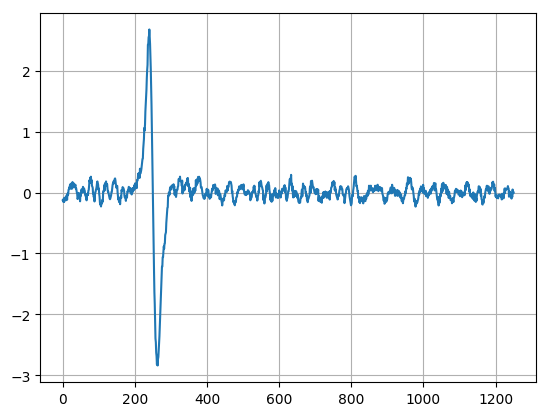

In [39]:
plot(ddprom)
grid()

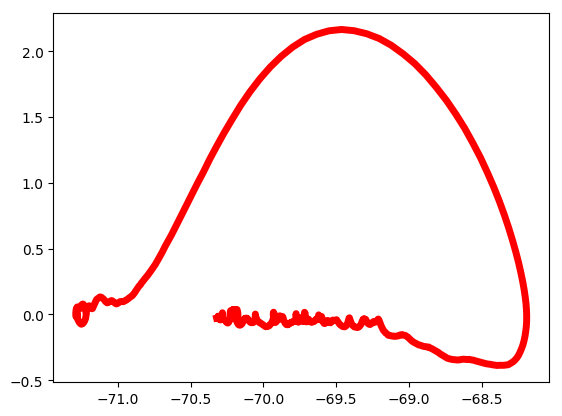

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcb984420f0>

In [40]:
plot(promSpK[1:end],difProm, lw=5, c="red")

In [41]:
riset=risetime(difProm)

(217, 280)

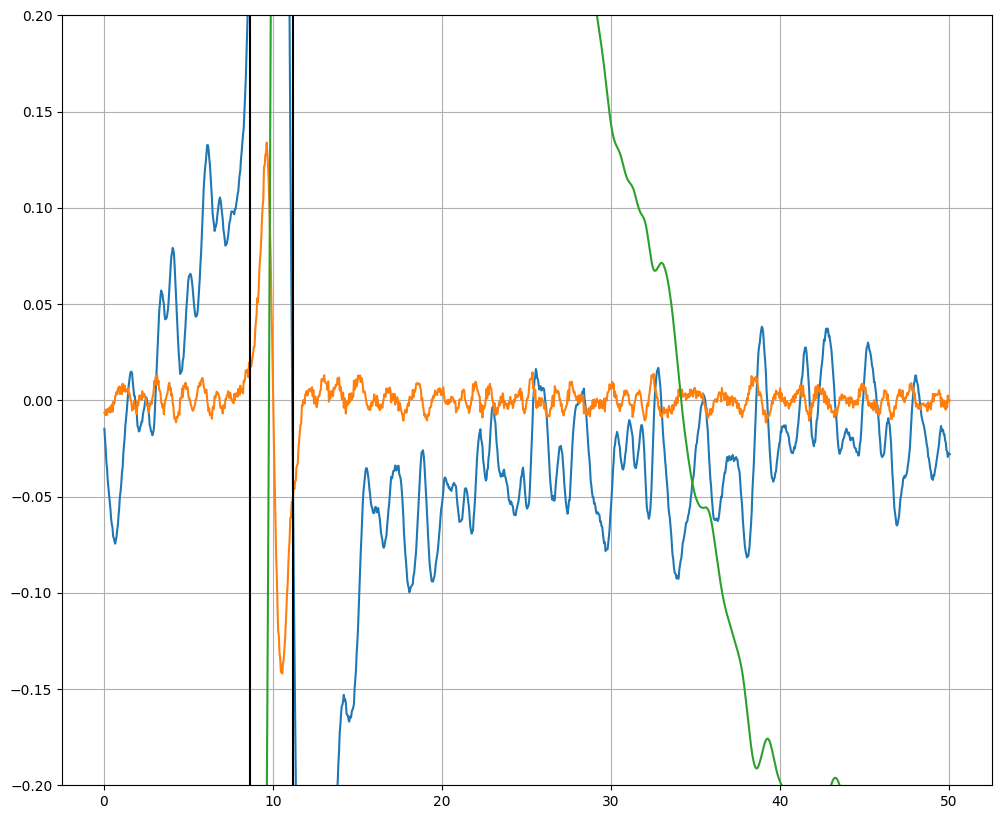

In [42]:
#plot(promSpK)
figure(figsize=(12,10))
ylim(-0.2,0.2)
plot(rangot,difProm)
plot(rangot,ddprom*0.05)
plot(rangot,promSpK.+70)
axvline(x=riset[1]/freq, c="black")
axvline(x=riset[2]/freq, c="black")

grid()

In [43]:
(riset[2]-riset[1])/freq

2.52

# Usaremos LsqFit y una funcion perrona para hacer ajuste por cachos

In [44]:
using LsqFit

### Vamos a arreglar esto para que las xzeros no necesiten los bordes... a no se yo creo si los vamos a tener que poner de todas formas

In [144]:
function lpp(x, xini, xfin, xzeros, yzeros, mzerouno)
    y=0
    
    ll=length(xzeros)+1
    
    #if ll!=length(yzeros)
     #   error("tu particion no contiene tantos parametros como necesitas")
    if (x<xini || x>=xfin)
        error("x fuera del dominio")
    end
    
    mzeros=zeros(ll)
    mzeros[1]=mzerouno
    xaux=vcat(xini, xzeros, xfin)   
    println(xaux)
    
    for k=2:ll
        
        mzeros[k]=(yzeros[k-1]-yzeros[k])*xaux[k]+mzeros[k-1]
    end
    

    
    for k=1:(ll-1)
        if xaux[k] <= x < xaux[k+1]
            println(xaux[k], " ", x, " ", xaux[k+1])
         y = yzeros[k]*x+mzeros[k]
        end
    end
    
    return y

end

lpp (generic function with 2 methods)

In [166]:
@. model3(x,p)=lpp(x, xi,xf, p[1:2], p[3:7], p[8])

model3 (generic function with 1 method)

[-1, 0, 2, 3]
0 1 2


4.0

In [162]:
ranguilllo=0.01:0.1:9.99
xzeros2=[3,4,5]
yzeros2=[-5, 5, 0.8, 0.1]
mzero2=10

10

In [163]:
yys=map(x->lpp(x, 0,10, xzeros2, yzeros2, mzero2), ranguilllo)

[0, 3, 4, 5, 10]
0 0.01 3
[0, 3, 4, 5, 10]
0 0.11 3
[0, 3, 4, 5, 10]
0 0.21 3
[0, 3, 4, 5, 10]
0 0.31 3
[0, 3, 4, 5, 10]
0 0.41 3
[0, 3, 4, 5, 10]
0 0.51 3
[0, 3, 4, 5, 10]
0 0.61 3
[0, 3, 4, 5, 10]
0 0.71 3
[0, 3, 4, 5, 10]
0 0.81 3
[0, 3, 4, 5, 10]
0 0.91 3
[0, 3, 4, 5, 10]
0 1.01 3
[0, 3, 4, 5, 10]
0 1.11 3
[0, 3, 4, 5, 10]
0 1.21 3
[0, 3, 4, 5, 10]
0 1.31 3
[0, 3, 4, 5, 10]
0 1.41 3
[0, 3, 4, 5, 10]
0 1.51 3
[0, 3, 4, 5, 10]
0 1.61 3
[0, 3, 4, 5, 10]
0 1.71 3
[0, 3, 4, 5, 10]
0 1.81 3
[0, 3, 4, 5, 10]
0 1.91 3
[0, 3, 4, 5, 10]
0 2.01 3
[0, 3, 4, 5, 10]
0 2.11 3
[0, 3, 4, 5, 10]
0 2.21 3
[0, 3, 4, 5, 10]
0 2.31 3
[0, 3, 4, 5, 10]
0 2.41 3
[0, 3, 4, 5, 10]
0 2.51 3
[0, 3, 4, 5, 10]
0 2.61 3
[0, 3, 4, 5, 10]
0 2.71 3
[0, 3, 4, 5, 10]
0 2.81 3
[0, 3, 4, 5, 10]
0 2.91 3
[0, 3, 4, 5, 10]
3 3.01 4
[0, 3, 4, 5, 10]
3 3.11 4
[0, 3, 4, 5, 10]
3 3.21 4
[0, 3, 4, 5, 10]
3 3.31 4
[0, 3, 4, 5, 10]
3 3.41 4
[0, 3, 4, 5, 10]
3 3.51 4
[0, 3, 4, 5, 10]
3 3.61 4
[0, 3, 4, 5, 10]
3 3.71 4
[0, 3, 4, 5,

100-element Array{Real,1}:
 9.95             
 9.45             
 8.95             
 8.45             
 7.95             
 7.45             
 6.95             
 6.45             
 5.949999999999999
 5.45             
 4.95             
 4.449999999999999
 3.95             
 ⋮                
 0                
 0                
 0                
 0                
 0                
 0                
 0                
 0                
 0                
 0                
 0                
 0                

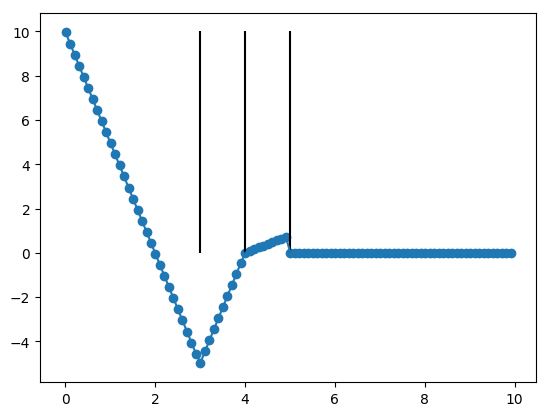

PyObject <matplotlib.collections.LineCollection object at 0x7fcb988dbfd0>

In [165]:
plot(ranguilllo, yys)
scatter(ranguilllo,yys)
vlines(xzeros2, 0,10)

# AHORA si es en serio:

In [170]:
paso=1/freq
tts=0:paso:50

0.0:0.04:50.0

In [169]:
freq

25.0

In [ ]:
np=pyimport("numpy")

In [ ]:
piezas=np[:piecewise]
piezas

## A partir de aquí estamos guardando datos

In [ ]:
using DelimitedFiles

In [ ]:
datos=hcat(promSpK[2:end],difProm)

In [ ]:
writedlm("../h5files/masterspikelet.dat", datos)

In [ ]:
nota="Esta espiguleta es el promedio de todas las detectadas automaticamente con el experimento  "*nomine

In [ ]:
h5open("../h5files/masterspiklet.h5", "w") do file
   write(file, "voltaje", promSpK[2:end])  # alternatively, say "@write file A"
    write(file, "derivative", difProm)  # alternatively, say "@write file A"
    write(file, "nota", nota)  # alternatively, say "@write file A"
end


In [ ]:

test = h5open("../h5files/masterspiklet.h5", "r");
names(test)

In [ ]:
#using HDF5